In [1]:
N = 8
J_value = 1
J_matrix_alpha = 1

In [2]:
import os
import numpy as np
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import eigsh
from scipy.interpolate import Akima1DInterpolator
from scipy.linalg import expm
import time
from scipy import sparse
import matplotlib.pyplot as plt
import pandas
import scipy
import torch
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device( "cpu")
np.set_printoptions(precision=6)
# initialize variables
# Q is the dimension
Q = pow(2, N)

# decimal number to binary array function
def D2B(num):
    string = f'{num:1b}'
    result = np.zeros(N - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# decimal number to binary array function
def D2B_with_digit(num,digit):
    string = f'{num:1b}'
    result = np.zeros(digit - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# binary array to decimal function
def B2D(array):
    res = 0
    for ele in array:
        res = (res << 1) | ele
    return res

def spin_reflection(array):
    new_array = np.zeros(len(array),dtype=int)
    for i in range(len(array)):
        if array[i] == 1:
            new_array[i] = 0
        else:
            new_array[i] = 1
    return new_array

def spatial_reflection(array):
    new_array = array[::-1]
    return new_array

# start my main function

# initialize J matrix
J_matrix = np.zeros((N, N), dtype='float64')

for i in range(N):
    for j in range(N):
        if j >= (i + 1):
            J_matrix[i][j] = J_value/pow(abs(i-j),J_matrix_alpha)

In [3]:
# start to get what product states are having the same symmtries
loop_state_list = np.linspace(0,Q-1,num=Q,dtype=int)

couple_state_matrix = []
sign_matrix = []
# this is the final result for the states to consctruct basis

for n in range(Q):  # n is an unused index

    # couple_num_list would be my result for each state we loop

    if len(loop_state_list)!=0: # loop for couple number for one state

        couple_num_list = [] # this is the list to store all the number that couple to the number we are looping
        couple_num_list = np.array(couple_num_list, dtype=int)
        state_num = loop_state_list[0]
        couple_num_list = np.append(couple_num_list,state_num)

        for m in range(Q): # loop for spin and spatial for all states inside the couple number list

            if m==0:

                couple_num_list_old =couple_num_list

                for i in range(len(couple_num_list)):
                    number = couple_num_list[i]
                    array = D2B(number)

                    # spin reflection
                    spin_relfection_array = spin_reflection(array)
                    spin_number = B2D(spin_relfection_array)
                    couple_num_list =np.append(couple_num_list,spin_number)



                    # # spatial reflection
                    spatial_relfection_array = spatial_reflection(array)
                    spatial_number = B2D(spatial_relfection_array)
                    couple_num_list =np.append(couple_num_list,spatial_number)

                    # remove the repeated element
                    couple_num_list = np.unique(couple_num_list)
            else:

                if len(couple_num_list_old) != len(couple_num_list):
                    # update couple_num_list_old first
                    couple_num_list_old =couple_num_list

                    for i in range(len(couple_num_list)):
                        number = couple_num_list[i]
                        array = D2B(number)

                        # spin reflection
                        spin_relfection_array = spin_reflection(array)
                        spin_number = B2D(spin_relfection_array)
                        couple_num_list =np.append(couple_num_list,spin_number)


                        # # spatial reflection
                        spatial_relfection_array = spatial_reflection(array)
                        spatial_number = B2D(spatial_relfection_array)
                        couple_num_list = np.append(couple_num_list,spatial_number)

                        # remove the repeated element
                        couple_num_list = np.unique(couple_num_list)

        # now we have final couple_num_list
        couple_state_matrix.append(couple_num_list.tolist())

        # remove the ones already found
        for j in range(len(couple_num_list)):
            loop_state_list = np.delete(loop_state_list, np.where(loop_state_list ==couple_num_list[j] ))

In [4]:
# initialize H matrix
couple_dimen = len(couple_state_matrix)

HA_matrix = np.zeros((couple_dimen, couple_dimen), dtype='float64')
HB_matrix = np.zeros((couple_dimen, couple_dimen), dtype='float64')

# loop each basis to fill in the diagonal elements for HA matrix

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )

    # loop each element inside the array
    normalization = len(state_array)

    # energy total for all the product states inside one basis

    e_tot = 0
    for j in range(len(state_array)):

        state = D2B(state_array[j])

        # loop over N sites to change the state vector to either 1 or -1

        for k in range(N):
            # 1 is spin down , 0 is spin up
            if state[k] == 1:
                state[k] = -1
            else:
                state[k] = 1

        # now get the energy, loop all the sites and then pairs

        for m in range(N):
            for q in range(N):
                e_temp = J_matrix[m][q] * state[m] * state[q]
                e_tot = e_tot + e_temp

    HA_matrix[i][i] = e_tot/normalization

# generate vector form for each basis
vector_form_basis_matrix = np.zeros((couple_dimen,Q))

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )
    normalization = np.sqrt(len(state_array))

    for j in state_array:
        vector_form_basis_matrix[i][j] = 1

    # put back normalization factor
    vector_form_basis_matrix[i] = vector_form_basis_matrix[i]/normalization

# loop each basis to fill in HB matrix

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )

    # this is the actual normalization unlike before since it will couple to some other states
    # so it can not be like just the square like we did before
    normalization = np.sqrt(len(state_array))

    # loop each product state to generate N other states, i.e. generaete the state after operator acting on it
    result_num_list = []
    result_num_list = np.array(result_num_list,dtype=int)
    for k in range(len(state_array)):

        spin = D2B(state_array[k])

        # start fliping the spins
        for j in range(N):
            if spin[j] == 1:
                # if it's spin down, raise to spin up
                spin[j] = 0
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list,new_num)
                # change it back for next operation
                spin[j] = 1
            else:
                # if it's spin down, raise to spin up
                spin[j] = 1
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list,new_num)
                # change it back for next operation
                spin[j] = 0


    # generate the vector form for the state after operrator acting on it

    vector_final_state = np.zeros(Q)

    for j in result_num_list:
        vector_final_state[j] = vector_final_state[j] +1

    # put back normalization factor
    vector_final_state = vector_final_state/normalization

    # calculate dot product to put into inside the matrix
    for j in range(couple_dimen):

        dot_product = np.dot(vector_final_state,vector_form_basis_matrix[j])
        HB_matrix[i][j] = dot_product

In [5]:
# # get true ground state
# B = 0.1   # !!! NEED TO BE CHANGED
# w, v = LA.eigh(HA_matrix + B* HB_matrix)
# inx = np.argsort(w)
# true_gs_vec = v[:, inx[0]]
# true_gs_energy =w[0]
# E_max =w[-1]

In [6]:
B = 0.1
# Compute the smallest eigenvalue and eigenvector
smallest_eigenvalue, smallest_eigenvector = eigsh(HA_matrix + B * HB_matrix, k=1, which='SA')

true_gs_energy = smallest_eigenvalue[0]
true_gs_vec = smallest_eigenvector[:, 0]

# Compute the largest eigenvalue
largest_eigenvalue = eigs(HA_matrix + B * HB_matrix, k=1, which='LR', return_eigenvectors=False)

E_max = largest_eigenvalue[0].real

In [7]:
true_gs_energy

-5.110650491789151

In [8]:
# get  ground state with numerically infinite large B field
# Compute the smallest eigenvalue and eigenvector
smallest_eigenvalue, smallest_eigenvector = eigsh( HB_matrix, k=1, which='SA')
temp_vec = smallest_eigenvector[:, 0]

In [9]:
# move to gpu
true_gs_vec = torch.tensor(true_gs_vec.astype(np.complex128)).to(device=device)
temp_vec = torch.tensor(temp_vec.astype(np.complex128)).to(device=device)

HA_matrix = torch.tensor(HA_matrix, dtype=torch.complex128).to(device=device)
HB_matrix = torch.tensor(HB_matrix, dtype=torch.complex128).to(device=device)
target_H = HA_matrix + B * HB_matrix

In [10]:
def get_fidelity_torch(vector1, vector2):
    overlap = torch.tensordot(vector1, vector2, dims=1)
    overlap_conj = torch.conj(overlap)
    fidelity = torch.real(overlap * overlap_conj)
    return fidelity

def get_energy_torch(matrix, vector):
    conj_vector = torch.conj(vector)
    energy = torch.real(torch.tensordot(conj_vector, torch.tensordot(matrix, vector, dims=1), dims=1))

    return energy

In [11]:
get_energy_torch(target_H,true_gs_vec).item()

-5.110650491789141

In [12]:
# get fidelity for t= 0s
fidelity_t_0 = get_fidelity_torch(true_gs_vec,temp_vec)
print(fidelity_t_0)

tensor(0.0162, dtype=torch.float64)


In [13]:
def lambda_evolve(x):
    global fidelity
    p = temp_vec.clone().to(torch.complex128)  # Create a copy of temp_vec

    for i in range(number_of_layers):
        H_matrix = HA_matrix + B_guess[i] * HB_matrix
        exp_imgH_matrix = torch.matrix_exp(-1j * x* H_matrix)
        new_p = torch.matmul(exp_imgH_matrix, p)
        p = new_p

    # fidelity = get_fidelity_torch(true_gs_vec, p)
    # print(fidelity)
    energy = get_energy_torch(target_H, p)
    # print(torch.norm(p).item())
    return energy

In [14]:
def exp_decay_guess(t_end,B_0,B_end,x):

    tau =  np.log(B_0/B_end)/t_end

    value = B_0*np.exp(-x*tau)

    return value
t_end = 40000  # Example value for t_end
B_0 = 10  # Example value for B_0
B_end = 0.1  # Example value for B_end

In [15]:
def lambda_evolve_filidety(x):
    global fidelity
    p = temp_vec.clone().to(torch.complex128)  # Create a copy of temp_vec

    for i in range(number_of_layers):
        H_matrix = HA_matrix + B_guess[i] * HB_matrix
        exp_imgH_matrix = torch.matrix_exp(-1j * x* H_matrix)
        new_p = torch.matmul(exp_imgH_matrix, p)
        p = new_p

    fidelity = get_fidelity_torch(true_gs_vec, p)
    return fidelity.item()

In [16]:
# Parameters
step_list = np.arange(50, 120, 10)
lambda_list = np.arange(1,5, 0.1)

# Initialize matrix to store fidelity values
fidelity_matrix = np.zeros((len(step_list), len(lambda_list)))

# Loop through parameters and calculate fidelity
for i, number_of_layers in enumerate(step_list):
    for j, dt_size in enumerate(lambda_list):
        x = np.linspace(0, t_end, number_of_layers)
        B_guess = exp_decay_guess(t_end, B_0, B_end, x)

        # Assuming lambda_evolve_fidelity returns a fidelity value
        fidelity = lambda_evolve_filidety(dt_size)  # Adjust this line according to your function
        #print(fidelity)
        # Store fidelity value in the matrix
        fidelity_matrix[i, j] = fidelity


# Best data is 100 layers with 1.153 as $\lambda_0$

In [22]:
# Save the matrix to a CSV file
# np.savetxt('fidelity_matrix.csv', fidelity_matrix, delimiter=',')


# Load the matrix from the CSV file
fidelity_matrix = np.loadtxt('fidelity_matrix.csv', delimiter=',')


In [18]:
# Find the maximum value in the matrix
max_value = np.max(fidelity_matrix)

# Find the indices of the maximum value
max_index = np.unravel_index(np.argmax(fidelity_matrix), fidelity_matrix.shape)

# max_index will be a tuple (i, j)
i, j = max_index

# Output the result
print(f"Maximum value: {max_value}")
print(f"Indices of maximum value: i = {i}, j = {j}")

Maximum value: 0.9912953052346107
Indices of maximum value: i = 5, j = 2


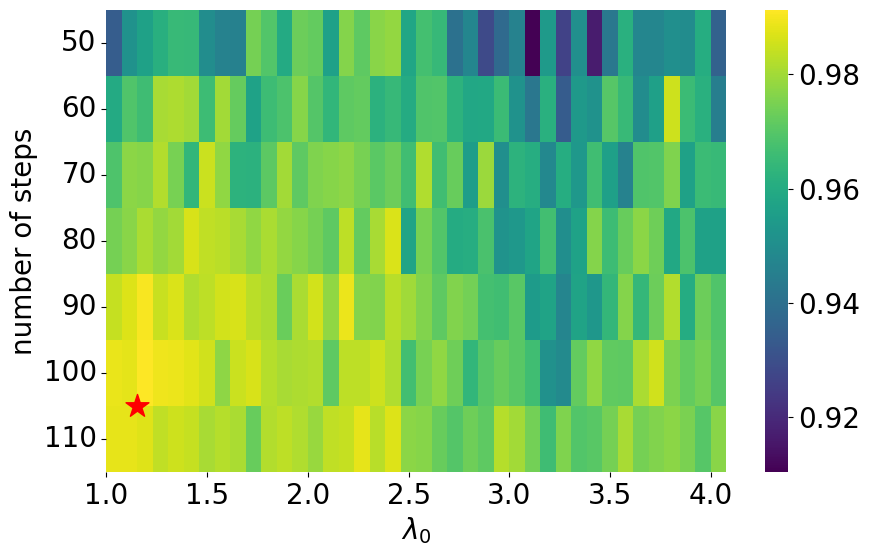

In [19]:
import seaborn as sns

# Define the specific x-axis tick positions and labels
specific_xticks = np.array([1, 1.5, 2, 2.5, 3, 3.5, 4])
specific_xticklabels = specific_xticks.astype(str)

# Plot heatmap using Seaborn
plt.figure(figsize=(10, 6))
ax = sns.heatmap(fidelity_matrix, cmap='viridis', cbar=True, annot=False,
                 xticklabels=specific_xticklabels,cbar_kws={'shrink': 1},
                 yticklabels=step_list)

# Adjust x-axis ticks
ax.set_xticks(np.linspace(0, len(lambda_list) - 1, len(specific_xticks)))
ax.set_xticklabels(specific_xticklabels, rotation=360)
# Adjust y-axis ticks and rotate labels
ax.set_yticklabels(step_list, rotation=360)  # Rotate y-axis labels 90 degrees

# Define the specific x and y coordinates for the star symbol
star_x = 1.2
star_y = 110
# Find closest indices to star_x and star_y in lambda_list and step_list
idx_x = np.abs(lambda_list - star_x).argmin()
idx_y = np.abs(step_list - star_y).argmin()

plt.xlabel(r'$\lambda_0$', size=20)  # LaTeX formatted xlabel
plt.ylabel('number of steps', size=20)

# Add a star symbol at the specified location
plt.scatter([idx_x], [idx_y], marker='*', color='red', s=300)

# Set font size of ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# Set font size of ticks on color bar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

# Save the figure
plt.savefig('constant_lambda_heatmap.png', bbox_inches='tight')
plt.show()